# AdaBoost

> [With AdaBoost], base classfiers are trained in sequence, and each base classifier is trained using a weighted form of the data set in which the weighting coefficient associated with each data point depends on the performance of the previous classifiers

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.tree import DecisionTreeClassifier

In [2]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

Let $\mathcal D = \big\{({\bf x}_n, t_n) \vert {\bf x}_n \in \mathbb{R}^D, t_n \in \{-1, 1\}\big\}_{n=1}^N$ a training dataset. AdaBoost defines an estimation function $G$ defined as

$$
    G({\bf x}) = \text{sign}\left(\sum_{m=1}^M \alpha_m \cdot G_m({\bf x})\right)
$$

* $\alpha_m$ is the weighting coefficient over $G_m$
* $G_m$ is known as the weak learner

#### AdaBoost M.1 Algorithm

1. Initialize $\forall n: w_n = 1/N$
2. For $m=1,\ldots, M$:
    1. Train $G_m$ using the weighting coefficients $\{w_n^{(m)}\}_{n=1}^N$
    2. Compute 
       $$
         \text{err}_m = \frac{\sum_{n=1}^N w_n^{(m)}\mathbb{1}\big(t_n \neq G_m({\bf x}_n)\big)}{\sum_{n=1}^N w^{(m)}_n}
       $$
    3. Compute 
        $$
            \alpha_m = \log\left(\frac{1 - \text{err}_m}{\text{err}_m}\right)
        $$
    4. Define 
        $$
        \forall n: w_n^{(m + 1)} = w_{n}^{(m)} \exp\left(\alpha_m \cdot \mathbb{1}\big(t_n \neq G_m({\bf x}_n\big)\right)
        $$
       
Once we've iterated AdaBoost for $M$ iterations, we proceed to make a prediction using
$$
    G({\bf x}) = \text{sign}\left(\sum_{m=1}^M \alpha_m G_m({\bf x})\right)
$$


----

We can train $G_m$ using the following cost function:
$$
    J_m = \sum_{n=1}^N w_n^{(m)}\mathbb{1}\big(t_n \neq G_m({\bf x}_n)\big)
$$

* From 2.D, we see that in subsequent iterations the weighting coefficients $w_n^{(m)}$ are increased for datapoints that are **misclassified**.
* Hence, at every step, AdaBoost places greater attention to data points that were misclassied on the previous iteration by increasing their weight.

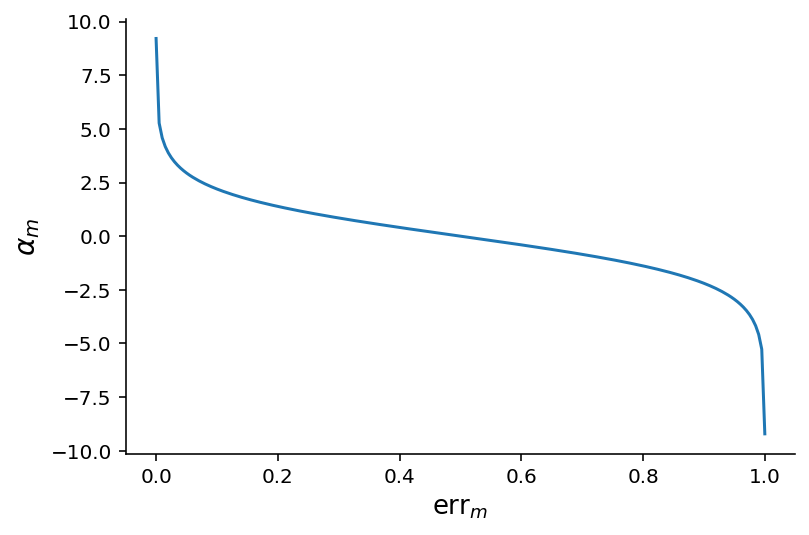

In [3]:
err_vals = np.linspace(1e-4, 1 - 1e-4, 200)
alpha_vals = np.log((1 - err_vals) / err_vals)
plt.plot(err_vals, alpha_vals)
plt.xlabel(r"err$_m$", fontsize=13);
plt.ylabel(r"$\alpha_m$", fontsize=14);

From the graph above we can see that weighting coefficients $\alpha_m$ give greater weight to the more accurate classifiers when computing $G$

## A practical example

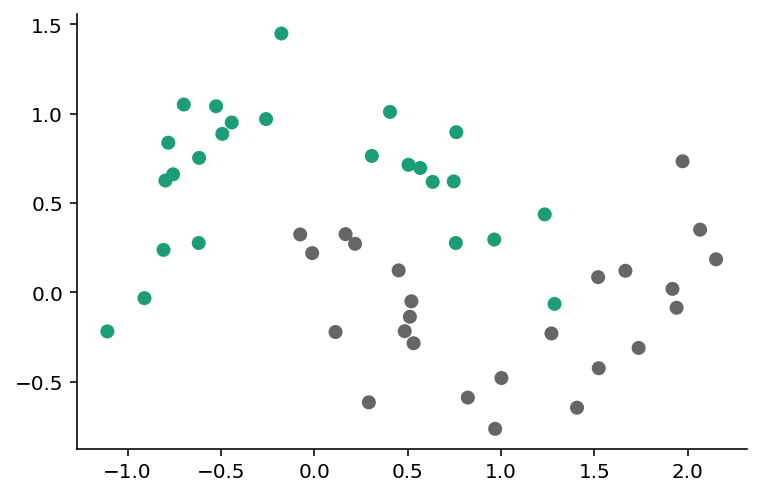

In [4]:
X, y = make_moons(n_samples=50, noise=0.2, random_state=3141)
y = 2 * y - 1
plt.scatter(*X.T, c=y, cmap="Dark2")

In [5]:
y

array([-1, -1,  1,  1, -1,  1,  1, -1, -1, -1, -1,  1,  1, -1, -1,  1,  1,
       -1,  1,  1, -1, -1,  1,  1,  1,  1,  1, -1, -1,  1,  1, -1,  1, -1,
        1, -1,  1, -1,  1, -1, -1,  1, -1,  1, -1, -1, -1, -1,  1,  1])

### Defining a single-split tree
(`see notebook on CART algorithm`)

In [6]:
def Ri(X, j, s):
    """
    Considering a dataset X, compute whether
    each of the observations belong to R1 or R2.
    We assing an observation x to be in R1 if
    x_j <= s; otherwise we asign it to R2. In other words,
    we define the subset R1 of X as
    
    R1 = {x | x_j <= s};
    R2 = X - R1
    """
    return X[:, j] <= s

def J(y, w=None):
    """
    AdaBoost M.1 error function
    """
    if not w:
        w = 1 / len(y)
    return 

def tree_erf(X, y, j, s):
    """
    Compute the objective error function for a decision tree model
    considering an index j in [0, .., D -1] and a cutoff point s.
    
    Parameters
    ----------
    X: Numpy array
        Dataset of shape (N, K)
    y: Numpy array
        Dataset of shape (N,)
    j: int
        The dimension to evaluate
    s: float
        The cutoff point
    """
    return J(y, Ri(X, j, s)) + J(y, ~Ri(X, j, s))


We can train $G_m$ using the following cost function:
$$
    J_m = \sum_{n=1}^N w_n^{(m)}\mathbb{1}\big(t_n \neq G_m({\bf x}_n)\big)
$$

In [ ]:
j = 1
vmin, vmax = X[:,j].min(), X[:,j].max() * 0.99
srange = np.linspace(vmin, vmax,  50)
s = min([(sh, tree_erf(X, y, j, sh)) for sh in srange], key=lambda v: v[1])

s

In [ ]:
plt.scatter(*X.T, c=y, cmap="Dark2")
plt.axhline(y=s[0])

In [8]:
w = np.ones_like(y) / len(y)

In [324]:
def Ri(X, j, s):
    return X[:, j] <= s

def find_partition(j, X, y, w, nrange=60):
    vmin, vmax = X[:,j].min(), X[:,j].max() * 0.99
    srange = np.linspace(vmin, vmax, nrange)
    yhat = Ri(X[..., None], j, srange)
    yhat = 2 * yhat - 1
    # Errors for each of the datapoints
    errs = yhat != y[:, None]
    # AdaBoost cost function
    Js = (errs * w[:, None]).sum(axis=0)
    # cutoff point
    s_cut = srange[Js.argmin()]
    return s_cut, Js.min(), errs[:, Js.argmin()]

In [343]:
partitions = [find_partition(j, X, -y * (-1) ** j, w) for j in [0, 1]]

errs = [element[-1] for element in partitions]
partitions = np.c_[[element[:-1] for element in partitions]]

In [344]:
j_cut = partitions[:, -1].argmin()

s_cut, J = partitions[j_cut]

In [352]:
err_m = (errs[j_cut] * w).sum() / w.sum()

In [355]:
alpha_m = np.log((1 - err_m) / err_m)

In [359]:
w * np.exp(alpha_m * errs[j_cut])

array([0.02 , 0.02 , 0.02 , 0.02 , 0.105, 0.02 , 0.02 , 0.02 , 0.02 ,
       0.02 , 0.02 , 0.02 , 0.02 , 0.02 , 0.105, 0.02 , 0.02 , 0.02 ,
       0.02 , 0.02 , 0.02 , 0.105, 0.02 , 0.02 , 0.02 , 0.02 , 0.105,
       0.02 , 0.02 , 0.02 , 0.02 , 0.02 , 0.02 , 0.105, 0.02 , 0.02 ,
       0.02 , 0.02 , 0.02 , 0.02 , 0.02 , 0.02 , 0.105, 0.02 , 0.105,
       0.02 , 0.105, 0.02 , 0.02 , 0.02 ])

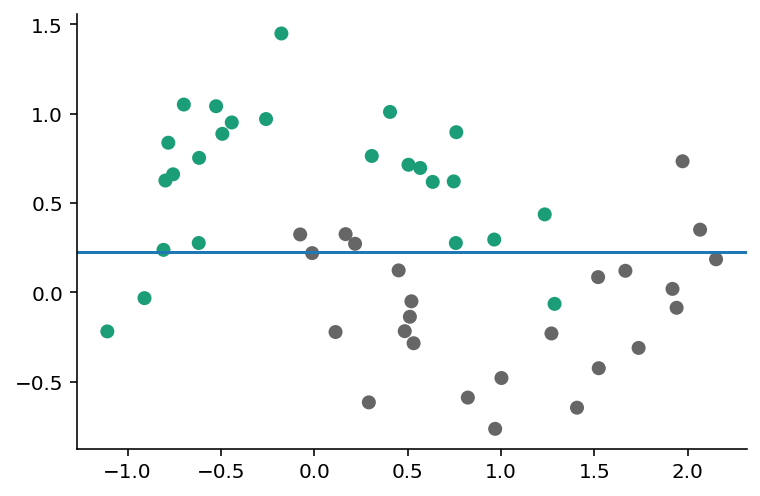

In [271]:
j = 1
s, J = find_partition(j, X, y, w)

if j == 1:
    plt.axhline(y=s)
else:
    plt.axvline(x=s)
plt.scatter(*X.T, c=y, cmap="Dark2")

In [204]:
srange = np.linspace(-0.76, 1.44, 30)
yhat = Ri(X[..., None], j, srange)
yhat = 2 * yhat - 1

In [205]:
Js = ((yhat != y[:, None]) * w[:, None]).sum(axis=0)
Js

array([0.48, 0.48, 0.44, 0.42, 0.4 , 0.38, 0.36, 0.32, 0.3 , 0.26, 0.28,
       0.26, 0.2 , 0.16, 0.22, 0.16, 0.18, 0.18, 0.18, 0.26, 0.3 , 0.32,
       0.38, 0.42, 0.48, 0.48, 0.48, 0.48, 0.48, 0.48])

In [297]:
Js.argmin()

13

In [202]:
Js.min()

0.16

In [195]:
srange[Js.argmin()]

0.22620689655172432

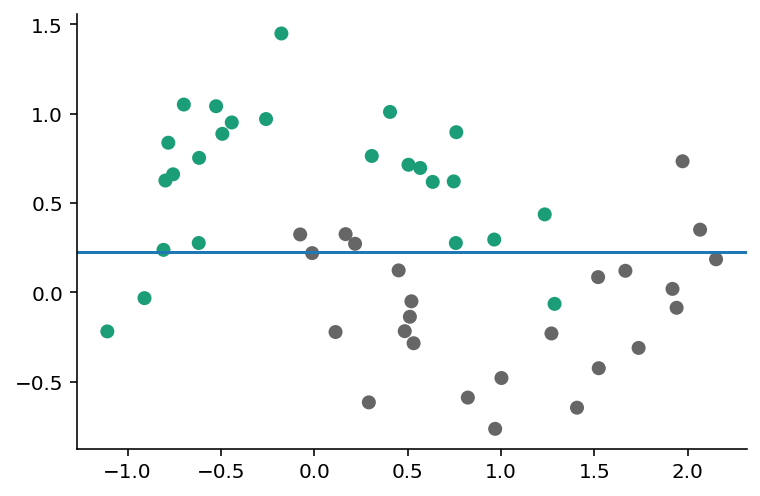

In [196]:
plt.axhline(y=srange[Js.argmin()])
plt.scatter(*X.T, c=y, cmap="Dark2")